# DAT405 Introduction to Data Science and AI 
## 2021-2022, Reading Period 1
## Assignment 4: Spam classification using Naïve Bayes 
There will be an overall grade for this assignment. To get a pass grade (grade 5), you need to pass items 1-3 below. To receive higher grades, finish items 4 and 5 as well. 

The exercise takes place in a notebook environment where you can chose to use Jupyter or Google Colabs. We recommend you use Google Colabs as it will facilitate remote group-work and makes the assignment less technical. 
Hints:
You can execute certain linux shell commands by prefixing the command with `!`. You can insert Markdown cells and code cells. The first you can use for documenting and explaining your results the second you can use writing code snippets that execute the tasks required.  

In this assignment you will implement a Naïve Bayes classifier in Python that will classify emails into spam and non-spam (“ham”) classes.  Your program should be able to train on a given set of spam and “ham” datasets. 
You will work with the datasets available at https://spamassassin.apache.org/old/publiccorpus/. There are three types of files in this location: 
-	easy-ham: non-spam messages typically quite easy to differentiate from spam messages. 
-	hard-ham: non-spam messages more difficult to differentiate 
-	spam: spam messages 

**Execute the cell below to download and extract the data into the environment of the notebook -- it will take a few seconds.** If you chose to use Jupyter notebooks you will have to run the commands in the cell below on your local computer, with Windows you can use 7zip (https://www.7-zip.org/download.html) to decompress the data.



In [1]:
#Download and extract data
!mkdir datasets
%cd datasets
!wget https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2 
!wget https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2 
!tar -xjf 20021010_easy_ham.tar.bz2 
!tar -xjf 20021010_hard_ham.tar.bz2
!tar -xjf 20021010_spam.tar.bz2
%cd ..

/home/islandengineer/Dev/Chalmers/dat405/assignment_4/datasets
--2021-09-23 13:51:39--  https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2
Resolving spamassassin.apache.org (spamassassin.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to spamassassin.apache.org (spamassassin.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1677144 (1.6M) [application/x-bzip2]
Saving to: ‘20021010_easy_ham.tar.bz2’

20021010_easy_ham.t 100%[===================>]   1.60M   581KB/s    in 2.8s    

2021-09-23 13:51:41 (581 KB/s) - ‘20021010_easy_ham.tar.bz2’ saved [1677144/1677144]

--2021-09-23 13:51:42--  https://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2
Resolving spamassassin.apache.org (spamassassin.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to spamassassin.apache.org (spamassassin.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102

*The* data is now in the three folders `easy_ham`, `hard_ham`, and `spam`.

In [2]:
!ls -lah

total 512K
drwxr-xr-x 3 islandengineer islandengineer 4.0K Sep 23 13:51 .
drwxr-xr-x 7 islandengineer islandengineer 4.0K Sep 23 11:31 ..
-rw-r--r-- 1 islandengineer islandengineer 159K Sep 23 13:51 DAT405_Assignment4.ipynb
-rw-r--r-- 1 islandengineer islandengineer 337K Sep 22 11:33 DAT405_Assignment4.pdf
drwxr-xr-x 5 islandengineer islandengineer 4.0K Sep 23 13:51 datasets


### 1. Preprocessing: 
1.	Note that the email files contain a lot of extra information, besides the actual message. Ignore that for now and run on the entire text. Further down (in the higher-grade part), you will be asked to filter out the headers and footers. 

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import os

In [4]:
def extract_emails(directories, class_name):
  rows = []
  for directory in directories:
    for file in os.listdir(directory):
      with open(os.path.join(directory,file), encoding='latin-1') as f:
        if f is not None:
          rows.append({'email': file, 'content': f.read(), 'class': class_name})
  return pd.DataFrame(rows)

# extract emails and add class information
df_easy_ham = extract_emails(['./datasets/easy_ham'], 'ham')
df_hard_ham = extract_emails(['./datasets/hard_ham'], 'ham')
df_spam = extract_emails(['./datasets/spam'], 'spam')

# join the two dataframes
df_combined = pd.concat([df_easy_ham, df_hard_ham, df_spam])

df_combined.sample(5)

,email,content,class
1792,0522.19fc2c700f36b246f3e1fb0807ce03fa,From fork-admin@xent.com Fri Sep 6 15:28:17 ...,ham
899,0733.782a236e90e0e7a55b3c67be6f7bef23,From fork-admin@xent.com Sat Sep 21 10:42:52 ...,ham
1849,0235.3c824d680d31b3710d8f3475730dc42d,From fork-admin@xent.com Wed Aug 28 10:50:30 ...,ham
498,0348.e0b89978fa806cf3e7fd3ba0869b3c65,Return-Path: ler@lerami.lerctr.org\nDelivery-D...,spam
62,0165.18c2e9e1217c3a39dc3b2b9199c061ff,From bounce-neatnettricks-2424157@silver.lyris...,ham


2.	We don’t want to train and test on the same data. Split the spam and the ham datasets in a training set and a test set. (`hamtrain`, `spamtrain`, `hamtest`, and `spamtest`)

In [5]:
# pre-processing code here
X = df_combined['content']
y = df_combined['class']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# print shapes
print('df_combined:', df_combined.shape)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

df_combined: (3302, 3)
X_train: (2641,)
X_test: (661,)
y_train: (2641,)
y_test: (661,)


### 2. Write a Python program that: 
1.	Uses four datasets (`hamtrain`, `spamtrain`, `hamtest`, and `spamtest`) 
2.	Trains a Naïve Bayes classifier (e.g. Sklearn) on `hamtrain` and `spamtrain`, that classifies the test sets and reports True Positive and False Negative rates on the `hamtest` and `spamtest` datasets. You can use `CountVectorizer` to transform the email texts into vectors. Please note that there are different types of Naïve Bayes Classifier in SKlearn ([Documentation here](https://scikit-learn.org/stable/modules/naive_bayes.html)). Test two of these classifiers that are well suited for this problem
- Multinomial Naive Bayes  
- Bernoulli Naive Bayes. 

Please inspect the documentation to ensure input to the classifiers is appropriate. Discuss the differences between these two classifiers. 





**Multinomial Naive Bayes**

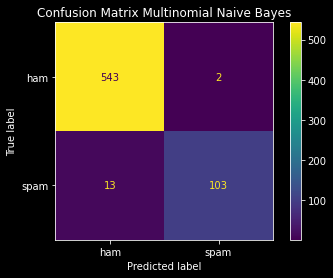

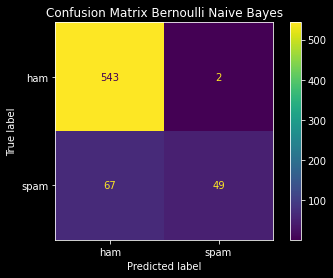

In [6]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import plot_confusion_matrix

def compare_naive_bayes(X_train, X_test, y_train, y_test, cv=None):
  # instantiate a Count Vectorizer and fit for training data
  if cv is None:
    cv = CountVectorizer()

  X_train_vector = cv.fit_transform(X_train)
  X_test_vector = cv.transform(X_test)

  # fit models using training vector
  multinomial_naive_bayes = MultinomialNB().fit(X_train_vector, y_train)
  bernoulli_naive_bayes = BernoulliNB().fit(X_train_vector, y_train)

  # plot confusion matrices
  plot_confusion_matrix(multinomial_naive_bayes, X_test_vector, y_test)
  plt.title('Confusion Matrix Multinomial Naive Bayes')
  plot_confusion_matrix(bernoulli_naive_bayes, X_test_vector, y_test)
  plt.title('Confusion Matrix Bernoulli Naive Bayes')

compare_naive_bayes(X_train, X_test, y_train, y_test)

As the confusion matrices show, the **Multinomial Naive Bayes** model outperforms the **Bernoulli Naive Bayes** model as it suffers from way less misclassifications, and consequently classifies new emails with a higher accuracy. Interestingly enough, both models seem to correctly classify "ham" or non-spam mail with similar accuracy. It's the false negative case, when the model classifies a spam mail as "ham", that separates the two models, with the **Multinomial Naive Bayes** model being more accurate here.

### 3.Run your program on 
-	Spam versus easy-ham 
-	Spam versus hard-ham.

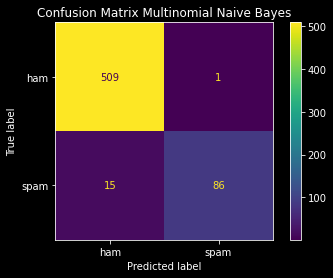

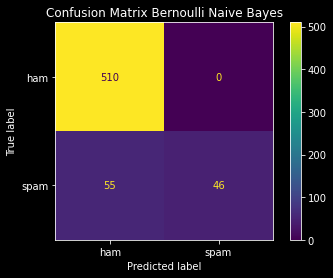

In [13]:
def spam_vs_easy_ham(cv=None):
  spam_vs_easy_ham = pd.concat([df_spam, df_easy_ham])
  X = spam_vs_easy_ham['content']
  y = spam_vs_easy_ham['class']
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
  compare_naive_bayes(X_train, X_test, y_train, y_test, cv=cv)

spam_vs_easy_ham()

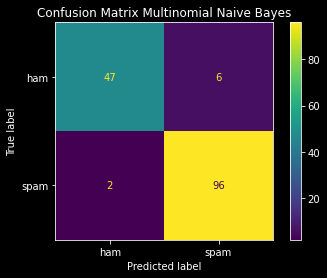

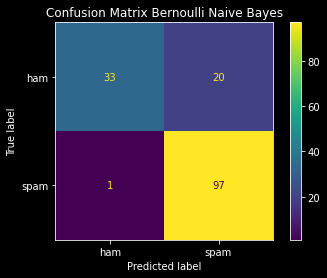

In [14]:
def spam_vs_hard_ham(cv=None):
  spam_vs_hard_ham = pd.concat([df_spam, df_hard_ham])
  X = spam_vs_hard_ham['content']
  y = spam_vs_hard_ham['class']
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
  compare_naive_bayes(X_train, X_test, y_train, y_test, cv=cv)

spam_vs_hard_ham()

### 4.	To avoid classification based on common and uninformative words it is common to filter these out. 

**a.** Argue why this may be useful. Try finding the words that are too common/uncommon in the dataset. 

Removing common and uninformative words removes what could be considered noise in the data, which might help improve the accuracy of the two classification models. For instance, looking at the 20 most common words below, one notices that most of these are most likely irrelevant for deciding if it's spam or ham.


In [24]:
def get_top_n_words(corpus, n=None):
    cv = CountVectorizer().fit(corpus)
    word_vector = cv.transform(corpus)
    word_sums = word_vector.sum(axis=0) 
    words_freq = [(word, word_sums[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda word: word[1], reverse=True)
    return words_freq[:n]

top_common_words = get_top_n_words(df_combined['content'])
top_common_words

[('com', 69898),
 ('the', 40824),
 ('to', 38179),
 ('http', 34048),
 ('from', 28715),
 ('td', 28399),
 ('2002', 28275),
 ('3d', 25415),
 ('for', 23845),
 ('net', 22839),
 ('font', 22609),
 ('with', 22181),
 ('by', 21436),
 ('width', 20932),
 ('of', 20336),
 ('and', 20232),
 ('localhost', 18916),
 ('id', 18226),
 ('received', 17800),
 ('www', 17481),
 ('example', 16310),
 ('list', 15478),
 ('in', 15093),
 ('org', 14914),
 ('11', 14820),
 ('tr', 14766),
 ('br', 13864),
 ('sep', 12483),
 ('fork', 12127),
 ('xent', 11848),
 ('height', 11760),
 ('is', 10929),
 ('src', 10797),
 ('img', 10663),
 ('gif', 10362),
 ('you', 10225),
 ('esmtp', 10189),
 ('09', 10009),
 ('that', 9644),
 ('size', 9466),
 ('10', 9436),
 ('0100', 9361),
 ('it', 9340),
 ('href', 9241),
 ('border', 8801),
 ('subject', 8612),
 ('127', 8340),
 ('table', 7952),
 ('this', 7736),
 ('on', 7568),
 ('sourceforge', 7274),
 ('mailto', 7036),
 ('version', 7005),
 ('face', 6683),
 ('aug', 6668),
 ('admin', 6643),
 ('jm', 6590),
 ('b

**b.** Use the parameters in Sklearn’s `CountVectorizer` to filter out these words. Update the program from point 3 and run it on your data and report your results.

You have two options to do this in Sklearn: either using the words found in part (a) or letting Sklearn do it for you. Argue for your decision-making.

**Using a custom list of stop words**

custom stop words: ['com', 'the', 'to', 'http', 'from', 'td', '2002', '3d', 'for', 'net', 'font', 'with', 'by', 'width', 'of', 'and', 'localhost', 'id', 'received', 'www']


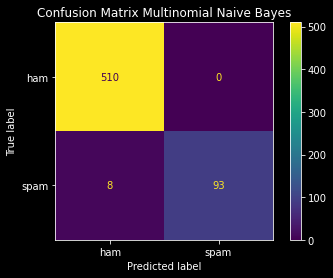

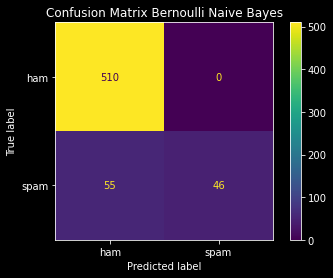

In [25]:
custom_stop_words = [word[0] for word in top_common_words[:20]]
print(f'custom stop words: {custom_stop_words}')

cv = CountVectorizer(stop_words=custom_stop_words)
spam_vs_easy_ham(cv)

**Using SKlearn's built in filtering**


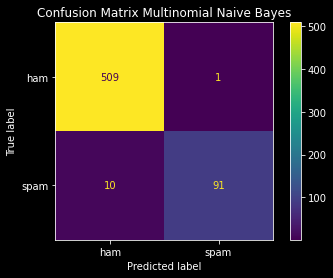

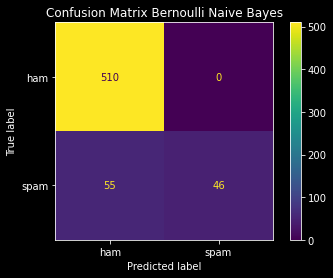

In [27]:
cv = CountVectorizer(max_df=0.9, stop_words='english')
spam_vs_easy_ham(cv=cv)

As mentioned in the question, one can either let `sklearn` filter out common words using  the built-in stop word list for English, or one can manually specify this list. In the documentation, the authors of the `sklern` library mention there are several known issues with using the built in stop word list and that one should consider an alternative. A reason to manually specify the stop words is that this allows for experimenting with different configuration which might fit the particular dataset a lot better. On the other hand this might also increase the risk of overfitting the models with the consequence of poor accuracy when presented with new emails.

We decided to go with the built in method as 

### 5. Eeking out further performance
Filter out the headers and footers of the emails before you run on them. The format may vary somewhat between emails, which can make this a bit tricky, so perfect filtering is not required. Run your program again and answer the following questions: 
-	Does the result improve from 3 and 4? 
- The split of the data set into a training set and a test set can lead to very skewed results. Why is this, and do you have suggestions on remedies? 
- What do you expect would happen if your training set were mostly spam messages while your test set were mostly ham messages? 

Re-estimate your classifier using `fit_prior` parameter set to `false`, and answer the following questions:
- What does this parameter mean?
- How does this alter the predictions? Discuss why or why not.

### What to report and how to hand in.

- You will need to clearly report all results in the notebook in a clear and appropriate way, either using plots or code output (f.x. "print statements"). 
- The notebook must be reproducible, that means, we must be able to use the `Run all` function from the `Runtime` menu and reproduce all your results. **Please check this before handing in.** 
- Save the notebook and share a link to the notebook (Press share in upper left corner, and use `Get link` option. **Please make sure to allow all with the link to open and edit.**
- Edits made after submission deadline will be ignored, graders will recover the last saved version before deadline from the revisions history.
- **Please make sure all cells are executed and all the output is clearly readable/visible to anybody opening the notebook.**